In [31]:
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import pickle
from lxml.html import fromstring
from collections import Counter
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
import sys
import pymongo
from pymongo import MongoClient
from newspaper import Article
import json
from string import digits
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.stem.porter import *
from collections import Counter 
from nltk.corpus import wordnet # To get words in dictionary with their parts of speech
from nltk.stem import WordNetLemmatizer # lemmatizes word based on it's parts of speech
from nltk.corpus import stopwords 
from textblob import TextBlob
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import cmudict
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from sklearn.metrics.pairwise import cosine_similarity
from numpy import dot
from numpy.linalg import norm
from scipy.stats import skew
import math


In [2]:
# data load from muckrack
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/Attempt3_mr_scrape.pickle', 'rb') as handle:
    scrapevar = pickle.load(handle)
    
# load writer df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_df.pickle', 'rb') as handle:
    writer_df = pickle.load(handle)

In [3]:
# Establish connection with database
client = MongoClient()
mydb = client["testinsightdb"]

In [4]:
currcol = mydb['zachlowe_nba']
y = currcol.find({"name": 'zachlowe_nba'})

In [23]:
# preprocessing functions
def clean_text(txtstr):
    txtstr = re.sub(r'\n\s*\n', '', txtstr) # extra lines
    txtstr = re.sub(r'[^\w\s]','',txtstr) # punctuation
    # for numbers
#     txtstr = re.sub(r'[^A-Za-z0-9(),!?@\'\`\"\_\n]', ' ', txtstr)
#     txtstr = re.sub(r'\w*\d\w*','',txtstr) # words with number plust letters
#     remove_digits = str.maketrans('', '', digits)
#     txtstr = txtstr.translate(remove_digits)
    txtstr = re.sub(' +',' ',txtstr) # extra white spaces
    txtstr = txtstr.lower()
    return txtstr

def clean_text_no_numbers(txtstr):
    txtstr = re.sub(r'\n\s*\n', '', txtstr) # extra lines
    txtstr = re.sub(r'[^\w\s]','',txtstr) # punctuation
    # for numbers
    txtstr = re.sub(r'[^A-Za-z0-9(),!?@\'\`\"\_\n]', ' ', txtstr)
    txtstr = re.sub(r'\w*\d\w*','',txtstr) # words with number plust letters
    remove_digits = str.maketrans('', '', digits)
    txtstr = txtstr.translate(remove_digits)
    txtstr = re.sub(' +',' ',txtstr) # extra white spaces
    txtstr = txtstr.lower()
    return txtstr

# remove stopwords
def remove_stopwords(word_tokens): # must be tokenized sentence
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

# stem long string - must be tokenized
def stemstr(txtstr):
    ps = PorterStemmer()
    newstr = [ps.stem(curr_word) for curr_word in txtstr]
    return newstr

# for figuring out what type of word
def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0] # first indexer for 
            # getting the top POS from list, second indexer for getting POS from tuple( POS: count )

# lemmatize long string - must be tokenized
def lemstr(txtstr):
    lz = WordNetLemmatizer()
    newstr = [lz.lemmatize(curr_word, get_pos(curr_word)) for curr_word in txtstr]
    return newstr

# get number of words
def get_nwords(txtstr):
    b = word_tokenize(txtstr)
    n_words = len(b)
    return n_words

# get number of sentences and nwords per sentences and sentence length variability
def get_nsentences(txtstr):
    b = sent_tokenize(txtstr)
    n_sentences = len(b)
    nwords = []
    for curr_sent in b:
        nwords.append(get_nwords(curr_sent))
    return n_sentences, np.mean(nwords), np.std(nwords)


# nsyll of a word
def nsyl(word):
    d = cmudict.dict()
    output = [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    return output


# n syllables of longer string
def n_syllables(txtstr):
    b = word_tokenize(txtstr)
    syll_each_word = []
    for curr_word in b:
        syll_each_word.append(nsyl(curr_word)[0])
    return syll_each_word

# number of words and word length variability
def get_word_length(txtsrt):
    tokens = word_tokenize(txtsrt)
    # Filter out punctuation
    no_punct_tokens = ([token for token in tokens 
                                            if any(c.isalpha() for c in token)])
    # Get a distribution of token lengths
    token_lengths = [len(token) for token in no_punct_tokens]
    return np.mean(token_lengths), np.std(token_lengths), skew(token_lengths)
        

# get flesch kincaid value
def get_fk_value(txtstr):
    # get n sentences
    a = word_tokenize(txtstr)
    n_words = len(a)
    # get n words
    b = sent_tokenize(txtstr)
    n_sentences = len(b)    
    score = 206.835 - 1.015 * (n_words / n_sentences) - 84.6 * (num_syllables / n_words)

def cos_sim(vec1,vec2):
    a = dot(vec1, vec2)/(norm(vec1)*norm(vec2))
    return a

In [21]:
curr_name = 'marc-stein'
currcol = mydb[curr_name]
y = currcol.find({"name": curr_name})
curr_art = y[0]
cleantext = clean_text(curr_art['article'])
tokens = word_tokenize(curr_art['article'])

# Filter out punctuation
no_punct_tokens = ([token for token in tokens 
                                        if any(c.isalpha() for c in token)])

# Get a distribution of token lengths
token_lengths = [len(token) for token in no_punct_tokens]
print(skew(token_lengths))

1.0196818540756216


In [38]:
# trying to calculate detla value
# Who are we dealing with this time?
authors = ("zachlowe_nba", "howardbeck", "marc-stein")

# Combine every paper except our test case into a single corpus
whole_corpus = []
for curr_name in authors:
    currcol = mydb[curr_name]
    y = currcol.find_one({"name": curr_name})
    tokens = word_tokenize(y['article'])
    # Filter out punctuation
    no_punct_tokens = ([token for token in tokens 
                                            if any(c.isalpha() for c in token)])
    whole_corpus += no_punct_tokens
    
# Get a frequency distribution
whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(30))
whole_corpus_freq_dist[ :10 ]

# The main data structure
features = [word for word,freq in whole_corpus_freq_dist]
feature_freqs = {}

for curr_name in authors:
    # A dictionary for each candidate's features
    feature_freqs[curr_name] = {} 
    
    # A helper value containing the number of tokens in the author's subcorpus
    currcol = mydb[curr_name]
    y = currcol.find_one({"name": curr_name})
    tokens = word_tokenize(y['article'])
    # Filter out punctuation
    no_punct_tokens = ([token for token in tokens 
                                            if any(c.isalpha() for c in token)])
    overall = len(no_punct_tokens)
    
    # Calculate each feature's presence in the subcorpus
    for feature in features:
        presence = no_punct_tokens.count(feature)
        feature_freqs[curr_name][feature] = presence / overall

# The data structure into which we will be storing the "corpus standard" statistics
corpus_features = {}

# For each feature...
for feature in features:
    # Create a sub-dictionary that will contain the feature's mean 
    # and standard deviation
    corpus_features[feature] = {}
    
    # Calculate the mean of the frequencies expressed in the subcorpora
    feature_average = 0
    for curr_name in authors:
        feature_average += feature_freqs[curr_name][feature]
    feature_average /= len(authors)
    corpus_features[feature]["Mean"] = feature_average
    
    # Calculate the standard deviation using the basic formula for a sample
    feature_stdev = 0
    for curr_name in authors:
        diff = feature_freqs[curr_name][feature] - corpus_features[feature]["Mean"]
        feature_stdev += diff*diff
    feature_stdev /= (len(authors) - 1)
    feature_stdev = math.sqrt(feature_stdev)
    corpus_features[feature]["StdDev"] = feature_stdev
    
feature_zscores = {}
for curr_name in authors:
    feature_zscores[curr_name] = {}
    for feature in features:
        
        # Z-score definition = (value - mean) / stddev
        # We use intermediate variables to make the code easier to read
        feature_val = feature_freqs[curr_name][feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        feature_zscores[curr_name][feature] = ((feature_val-feature_mean) / 
                                            feature_stdev)
        
# Tokenize the test case
test_instance = 'zachlowe_nba'
currcol = mydb[test_instance]
y = currcol.find({"name": test_instance})
testcase_tokens = word_tokenize(y[3]['article'])
    
# Filter out punctuation and lowercase the tokens
testcase_tokens = [token.lower() for token in testcase_tokens 
                   if any(c.isalpha() for c in token)]
 
# Calculate the test case's features
overall = len(testcase_tokens)
testcase_freqs = {}
for feature in features:
    presence = testcase_tokens.count(feature)
    testcase_freqs[feature] = presence / overall
    
# Calculate the test case's feature z-scores
testcase_zscores = {}
for feature in features:
    feature_val = testcase_freqs[feature]
    feature_mean = corpus_features[feature]["Mean"]
    feature_stdev = corpus_features[feature]["StdDev"]
    testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    print("Test case z-score for feature", feature, "is", testcase_zscores[feature])
    
for author in authors:
    delta = 0
    for feature in features:
        delta += math.fabs((testcase_zscores[feature] - 
                            feature_zscores[author][feature]))
    delta /= len(features)
    print( "Delta score for candidate", author, "is", delta )

Test case z-score for feature the is 0.1949608117666349
Test case z-score for feature a is 0.7728176131085696
Test case z-score for feature and is -0.005413802816517375
Test case z-score for feature of is 0.005906725769884051
Test case z-score for feature to is 1.6460600385884703
Test case z-score for feature in is -0.1007271100645814
Test case z-score for feature is is 0.6227703094536208
Test case z-score for feature that is 0.25394338490955964
Test case z-score for feature 's is 0.35607032534107996
Test case z-score for feature The is -1.1545883725325932
Test case z-score for feature I is -0.8830725225835225
Test case z-score for feature for is 0.21370271137938873
Test case z-score for feature on is 1.6362837192556003
Test case z-score for feature it is 9.42425817762349
Test case z-score for feature as is -0.7733751122298926
Test case z-score for feature at is -0.6856159223149387
Test case z-score for feature an is -0.4364006444523874
Test case z-score for feature not is 0.0464811372

In [48]:
y.count()

/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


400

In [70]:
# lets build corpus of all writers sampling 10 articles from each author
authors = list(set(writer_feature_df['author_list']))
t = time.time()
# authors = ['zachlowe_nba', 'marc-stein', 'howard-beck']
npieces_sample = 50

# Combine every paper except our test case into a single corpus
whole_corpus = []
all_tokens_by_author = {}
for curr_name in authors:
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    ninsample = y.count()
    article_idx_to_sample = random.sample(range(0,ninsample), np.min([ninsample,npieces_sample]))
    # for saving tokens for later
    all_tokens_by_author[curr_name] = []
    for i in article_idx_to_sample:
        tokens = word_tokenize(y[i]['article'])
        # Filter out punctuation
        no_punct_tokens = ([token for token in tokens 
                                                if any(c.isalpha() for c in token)])
        all_tokens_by_author[curr_name] += no_punct_tokens
        whole_corpus += no_punct_tokens
    
# Get a frequency distribution
whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(30))
whole_corpus_freq_dist[ :10 ]

# The main data structure
features = [word for word,freq in whole_corpus_freq_dist]
feature_freqs = {}

for curr_name in authors:
    # A dictionary for each candidate's features
    feature_freqs[curr_name] = {} 
    
#     # A helper value containing the number of tokens in the author's subcorpus
#     currcol = mydb[curr_name]
#     y = currcol.find_one({"name": curr_name})
#     tokens = word_tokenize(y['article'])
#     # Filter out punctuation
#     no_punct_tokens = ([token for token in tokens 
#                                             if any(c.isalpha() for c in token)])
    overall = len(all_tokens_by_author[curr_name])
    if overall == 0:
        overall = 1
    
    # Calculate each feature's presence in the subcorpus
    for feature in features:
        presence = all_tokens_by_author[curr_name].count(feature)
        feature_freqs[curr_name][feature] = presence / overall

# The data structure into which we will be storing the "corpus standard" statistics
corpus_features = {}

# For each feature...
for feature in features:
    # Create a sub-dictionary that will contain the feature's mean 
    # and standard deviation
    corpus_features[feature] = {}
    
    # Calculate the mean of the frequencies expressed in the subcorpora
    feature_average = 0
    for curr_name in authors:
        feature_average += feature_freqs[curr_name][feature]
    feature_average /= len(authors)
    corpus_features[feature]["Mean"] = feature_average
    
    # Calculate the standard deviation using the basic formula for a sample
    feature_stdev = 0
    for curr_name in authors:
        diff = feature_freqs[curr_name][feature] - corpus_features[feature]["Mean"]
        feature_stdev += diff*diff
    feature_stdev /= (len(authors) - 1)
    feature_stdev = math.sqrt(feature_stdev)
    corpus_features[feature]["StdDev"] = feature_stdev

feature_zscores = {}
for curr_name in authors:
    feature_zscores[curr_name] = {}
    for feature in features:
        
        # Z-score definition = (value - mean) / stddev
        # We use intermediate variables to make the code easier to read
        feature_val = feature_freqs[curr_name][feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        feature_zscores[curr_name][feature] = ((feature_val-feature_mean) / 
                                            feature_stdev)
elapsed = time.time() - t
print(elapsed)

/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  del sys.path[0]


8.65278697013855


In [82]:
# now for test case
# Tokenize the test case
test_instance = 'zachlowe_nba'
currcol = mydb[test_instance]
y = currcol.find({"name": test_instance})
ninsample = y.count()
article_idx_to_sample = random.sample(range(0,ninsample), 1)
testcase_tokens = word_tokenize(y[article_idx_to_sample[0]]['article'])
    
# Filter out punctuation and lowercase the tokens
testcase_tokens = [token.lower() for token in testcase_tokens 
                   if any(c.isalpha() for c in token)]
 
# Calculate the test case's features
overall = len(testcase_tokens)
testcase_freqs = {}
for feature in features:
    presence = testcase_tokens.count(feature)
    testcase_freqs[feature] = presence / overall
    
# Calculate the test case's feature z-scores
testcase_zscores = {}
for feature in features:
    feature_val = testcase_freqs[feature]
    feature_mean = corpus_features[feature]["Mean"]
    feature_stdev = corpus_features[feature]["StdDev"]
    testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
#     print("Test case z-score for feature", feature, "is", testcase_zscores[feature])

author_deltas = []
for author in authors:
    delta = 0
    for feature in features:
        delta += math.fabs((testcase_zscores[feature] - 
                            feature_zscores[author][feature]))
    delta /= len(features)
#     print( "Delta score for candidate", author, "is", delta )
    author_deltas.append(delta)

/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


In [83]:
tmp_df = pd.DataFrame.from_dict({'deltas': author_deltas, "author_list": authors})
tmp_df.sort_values(by='deltas')

,deltas,author_list
27,0.877604,kevin-arnovitz
10,0.889636,ramona-shelburne
52,0.934510,chris_broussard
109,0.934627,howardbeck
45,0.949967,mark-deeks
31,0.962408,ken-berger
59,0.973505,andrew-bernucca
79,0.982997,marc-stein
63,0.984648,zachlowe_nba
38,1.000030,seerat-sohi


In [12]:
# add some basic features for each article
mongo_id = []
n_words = []
n_sentences = []
n_wordspersentence = []
n_word_sent_var = []
author_list = []
author_id_n = []
n_nouns = []
n_adj = []
n_verb = []
n_adv =[]
# for sentiment analysis
analyzer = SentimentIntensityAnalyzer()
avg_sentim = []
sentim_var = []
# for more specific pos
# adj, comp adj, super adj, noun, proper sing n, proper pl n, 
# plural n, adv, comp adv, super avd
pos_test = ['JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNPS', 'NNS', 'RB', 'RBR', 'RBS']
extra_pos = {}
for curr_pos in pos_test:
    extra_pos[curr_pos] = []

# iterate over all writers
for curr_name in writer_df['website_name']:
    print(curr_name)
    t = time.time()
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    for curr_art in y:
        # mongo id number
        mongo_id.append(str(curr_art['_id']))
        # n words after cleaning and removing numbers and punctuation
        cleantext = clean_text(curr_art['article'])
        n_words.append(get_nwords(cleantext))
        # n sentences
        ns, nw_s, nw_s_var = get_nsentences(curr_art['article'])
        n_sentences.append(ns)
        n_wordspersentence.append(nw_s)
        n_word_sent_var.append(nw_s_var)
        # author list
        author_list.append(curr_name)
        # author id n
        author_id_n.append(curr_art['writer_id'])
        # remove stopwords from story
        nostopwords = remove_stopwords(word_tokenize(cleantext))
        typesofspeech = [get_pos(i) for i in nostopwords]
        n_nouns.append(typesofspeech.count('n'))
        n_adj.append(typesofspeech.count('a'))
        n_verb.append(typesofspeech.count('v'))
        n_adv.append(typesofspeech.count('r'))
        sentim_all = {}
        sentim_all['neg'] = []
        sentim_all['neu'] = []
        sentim_all['pos'] = []
        sentim_all['compound'] = []
        sentences = sent_tokenize(curr_art['article'])
        for i in sentences:
            vs = analyzer.polarity_scores(i)
            sentim_all['neg'].append(vs['neg'])
            sentim_all['neu'].append(vs['neu'])
            sentim_all['pos'].append(vs['pos'])
            sentim_all['compound'].append(vs['compound'])
        # take avg sentim for each story by averaging sentim for each sentence
        avg_sentim.append([np.mean(sentim_all['neg']), np.mean(sentim_all['neu']), 
                         np.mean(sentim_all['pos']), np.mean(sentim_all['compound'])])
        # take std of sentim for each story to measure sentiment variability
        sentim_var.append([np.std(sentim_all['neg']), np.std(sentim_all['neu']), 
                         np.std(sentim_all['pos']), np.std(sentim_all['compound'])])
    elapsed = time.time() - t
    print(elapsed)
#         # for more specific pos
#         doc = nlp(curr_art['article'])
#         pos_vec = [token.tag_ for token in doc]        
#         for curr_pos in pos_test:
#             extra_pos[curr_pos].append(pos_vec.count(curr_pos))
          

zachlowe_nba
38.73399114608765
adrian-wojnarowski
8.622598886489868
lee-jenkins
28.317741870880127
howardbeck
10.94846487045288
marc-stein
6.440454006195068
ethan-sherwood-strauss
6.862703800201416
jason-concepcion
4.641931056976318
kevin-arnovitz
11.989131927490234
tom-haberstroh
12.1701500415802
nate-duncan


/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.9044158458709717
zach-harper
2.1899027824401855
brian-windhorst
7.968173980712891
sam_amick
5.707959175109863
david-aldridge
17.333062171936035
ramona-shelburne
10.05358600616455
jpdabrams
11.040386199951172
kevin-pelton
11.32152795791626
marc-j-spears
12.16173005104065
matt-moore
11.606884002685547
shams-charania
5.440387010574341
kevin-p-oconnor
1.7267799377441406
chris-haynes
5.4901556968688965
dave-mcmenamin
7.003241777420044
shea-serrano
14.327958106994629
ian-begley
4.37597393989563
rachel-nichols
1.0117440223693848
ben-golliver
11.619072198867798
mike-prada
7.112704038619995
robmahoney
13.476242780685425
tim-macmahon
5.6943700313568115
chris-herring
6.495636224746704
billsimmons
5.670539855957031
jonathan-tjarks
12.951073169708252
amin-elhassen
0.0009350776672363281
bobby-marks
6.664451837539673
danny-leroux
5.884143114089966
chris-mannix
10.196951150894165
dan-devine
13.129455804824829
michael-pina
14.92750096321106
thompsonscribe
3.108916997909546
ben-golliver
11.34837388992

In [177]:
analyzer = SentimentIntensityAnalyzer()
avg_sentim = []
sentim_var = []
for curr_name in writer_df['website_name']:
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    for curr_art in y:
        sentim_all = {}
        sentim_all['neg'] = []
        sentim_all['neu'] = []
        sentim_all['pos'] = []
        sentim_all['compound'] = []
        sentences = sent_tokenize(curr_art['article'])
        for i in sentences:
        #             a = clean_text(i)
            vs = analyzer.polarity_scores(i)
            sentim_all['neg'].append(vs['neg'])
            sentim_all['neu'].append(vs['neu'])
            sentim_all['pos'].append(vs['pos'])
            sentim_all['compound'].append(vs['compound'])
        # take avg sentim for each story by averaging sentim for each sentence
        avg_sentim.append([np.mean(sentim_all['neg']), np.mean(sentim_all['neu']), 
                         np.mean(sentim_all['pos']), np.mean(sentim_all['compound'])])
        # take std of sentim for each story to measure sentiment variability
        sentim_var.append([np.std(sentim_all['neg']), np.std(sentim_all['neu']), 
                         np.std(sentim_all['pos']), np.std(sentim_all['compound'])])
    


/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [147]:
# build a pd of what we have so far
data = {'n_words': n_words, 'author_id_n': author_id_n, 'author_list': author_list, 'mongo_id': mongo_id,
        'n_nouns': n_nouns, 'n_adj': n_adj, 'n_verb': n_verb, 'n_adv': n_adv, 'n_sentences': n_sentences, 
        'n_wordspersentence': n_wordspersentence, 'n_wordspersent_variability': n_word_sent_var, 
        'neg_sent': [i[0] for i in avg_sentim], 'neu_sent': [i[1] for i in avg_sentim],
        'pos_sent': [i[2] for i in avg_sentim], 'neg_sent_var': [i[0] for i in sentim_var], 
       'neu_sent_var': [i[1] for i in sentim_var], 'pos_sent_var': [i[2] for i in sentim_var]}
writer_feature_df = pd.DataFrame.from_dict(data)
writer_feature_df.head()
# print(len(n_nouns))

,n_words,author_id_n,author_list,mongo_id,n_nouns,n_adj,n_verb,n_adv,n_sentences,n_wordspersentence,n_wordspersent_variability,neg_sent,neu_sent,pos_sent,neg_sent_var,neu_sent_var,pos_sent_var
0,2966,693716,zachlowe_nba,5b9c705c11919a2b1a15c30d,1245,67,413,102,185,19.854054,17.212670,0.078108,0.839638,0.082249,0.134054,0.185814,0.143422
1,2966,693716,zachlowe_nba,5b9c705d11919a2b1a15c30e,1245,67,413,102,185,19.854054,17.212670,0.078108,0.839638,0.082249,0.134054,0.185814,0.143422
2,2697,693716,zachlowe_nba,5b9c705f11919a2b1a15c30f,1000,60,363,112,151,20.774834,16.185666,0.037828,0.869960,0.092225,0.083719,0.139230,0.123817
3,2813,693716,zachlowe_nba,5b9c706011919a2b1a15c310,1060,58,411,86,183,18.568306,11.751734,0.059246,0.854087,0.086639,0.106565,0.143424,0.122222
4,2813,693716,zachlowe_nba,5b9c706111919a2b1a15c311,1060,58,411,86,183,18.568306,11.751734,0.059246,0.854087,0.086639,0.106565,0.143424,0.122222


In [7]:
# write to postgresql database for later pulling
dbname = 'writer_feature_db'
username = 'rohanramesh' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))
# writer_feature_df.to_sql('writer_feature', engine, if_exists='replace')

postgres://rohanramesh@localhost/writer_feature_db
True


In [8]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)

In [10]:
# query to load entire db into pandas
sql_query = """
SELECT * FROM writer_feature;
"""
writer_feature_df = pd.read_sql_query(sql_query,con)

In [9]:

# query to test subsections
sql_query = """
SELECT * FROM writer_feature WHERE author_list ='timkawakami';
"""
writer_feature_subsection = pd.read_sql_query(sql_query,con)
writer_feature_subsection.head(10)

,index,n_words,author_id_n,author_list,mongo_id,n_nouns,n_adj,n_verb,n_adv,n_sentences,n_wordspersentence,n_wordspersent_variability,neg_sent,neu_sent,pos_sent,neg_sent_var,neu_sent_var,pos_sent_var
0,10504,331,693806,timkawakami,5b9ccc3011919a2b1a15eb5b,112,4,50,14,15,28.400000,12.642785,0.010533,0.939667,0.049800,0.039412,0.097387,0.079268
1,10505,159,693806,timkawakami,5b9ccc3111919a2b1a15eb5c,51,3,21,6,9,22.555556,14.599171,0.017222,0.866222,0.116556,0.032365,0.128622,0.123400
2,10506,154,693806,timkawakami,5b9ccc3411919a2b1a15eb5d,53,3,24,6,12,15.416667,16.675623,0.115667,0.844167,0.040167,0.241314,0.248116,0.110572
3,10507,156,693806,timkawakami,5b9ccc3511919a2b1a15eb5e,62,0,18,6,8,22.375000,13.918850,0.049000,0.889250,0.061750,0.086324,0.104215,0.089965
4,10508,154,693806,timkawakami,5b9ccc3711919a2b1a15eb5f,53,2,18,7,6,30.500000,15.217862,0.019833,0.892667,0.087500,0.044349,0.100472,0.107697
5,10509,147,693806,timkawakami,5b9ccc3a11919a2b1a15eb60,59,4,17,6,9,20.555556,16.364671,0.015000,0.906556,0.078444,0.030529,0.118191,0.097638
6,10510,150,693806,timkawakami,5b9ccc3b11919a2b1a15eb61,59,5,16,4,9,20.777778,20.241749,0.000000,0.945556,0.054444,0.000000,0.081021,0.081021
7,10511,799,693806,timkawakami,5b9ccc3d11919a2b1a15eb62,289,24,96,35,43,23.302326,12.570795,0.072767,0.815558,0.111721,0.090451,0.176715,0.145012
8,10512,157,693806,timkawakami,5b9ccc3f11919a2b1a15eb63,59,6,24,5,8,23.625000,12.398967,0.053625,0.914750,0.031625,0.099345,0.109978,0.042018
9,10513,156,693806,timkawakami,5b9ccc4111919a2b1a15eb64,57,0,21,3,9,21.666667,12.128937,0.023889,0.887111,0.089000,0.051317,0.127154,0.129004


In [151]:
# # save writer feature df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_feature_df_3.pickle', 'wb') as handle:
    pickle.dump(writer_feature_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load
# with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_feature_df_2.pickle', 'rb') as handle:
#     writer_feature_df = pickle.load(handle)

In [11]:
# lets build features that will put in
# Features to include:
    # n_words
    # n_nouns/n_words
    # n_adj/n_words
    # n_verb/n_words
    # n_adv/n_words
    # n_sentences
    # n_wordspersentence
    # n_wordspersentence_variability
    # positive sentiment
    # neu sentiment
    # negative sentiment
    # positive sentiment variability
    # neu sentiment variability
    # negative sentiment variability

# do fractions
writer_feature_df['noun_fraction'] = writer_feature_df['n_nouns']/writer_feature_df['n_words']
writer_feature_df['adj_fraction'] = writer_feature_df['n_adj']/writer_feature_df['n_words']
writer_feature_df['adv_fraction'] = writer_feature_df['n_adv']/writer_feature_df['n_words']
writer_feature_df['verb_fraction'] = writer_feature_df['n_verb']/writer_feature_df['n_words']


In [12]:
features_use = ['n_words', 'noun_fraction', 'adj_fraction', 'adv_fraction', 'verb_fraction', 
               'neg_sent', 'pos_sent', 'neu_sent', 'neg_sent_var', 'neu_sent_var', 'pos_sent_var', 
               'n_sentences', 'n_wordspersentence', 'n_wordspersent_variability', 'author_list']
writer_feature_df_2 = writer_feature_df[features_use]
writer_feature_df_2.replace([np.inf, -np.inf], np.nan)
writer_feature_df_2 = writer_feature_df_2.dropna(axis=0, how='any')
# pd.isna(writer_feature_df_2)
print(np.shape(writer_feature_df_2))

(15964, 15)


In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
input_1 = pd.DataFrame.transpose(writer_feature_df_2)
pca.fit(input_1)
# a = writer_feature_df_2['n_wordspersentence']
# a.isnull().values.any()
a = pca.components_ 

(2, 15964)


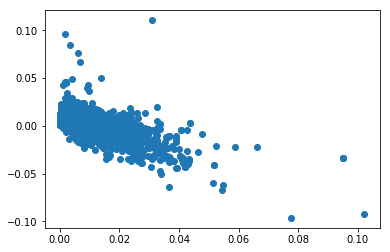

In [96]:
print(np.shape(a))
plt.plot(a[0],a[1],'o')

In [13]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=1, perplexity=30, 
                  n_iter=1000).fit_transform(writer_feature_df_2.drop('author_list', axis=1))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15964 samples in 0.012s...
[t-SNE] Computed neighbors for 15964 samples in 0.407s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15964
[t-SNE] Computed conditional probabilities for sample 2000 / 15964
[t-SNE] Computed conditional probabilities for sample 3000 / 15964
[t-SNE] Computed conditional probabilities for sample 4000 / 15964
[t-SNE] Computed conditional probabilities for sample 5000 / 15964
[t-SNE] Computed conditional probabilities for sample 6000 / 15964
[t-SNE] Computed conditional probabilities for sample 7000 / 15964
[t-SNE] Computed conditional probabilities for sample 8000 / 15964
[t-SNE] Computed conditional probabilities for sample 9000 / 15964
[t-SNE] Computed conditional probabilities for sample 10000 / 15964
[t-SNE] Computed conditional probabilities for sample 11000 / 15964
[t-SNE] Computed conditional probabilities for sample 12000 / 15964
[t-SNE] Computed conditional probabilities for sam

(15964, 2)


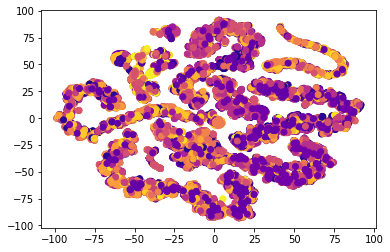

In [14]:
print(np.shape(X_embedded))
all_authors = writer_feature_df_2['author_list']
unique_authors = list(set(all_authors))
cm = plt.get_cmap('plasma_r',len(unique_authors))
cmap_colors = [cm.colors[unique_authors.index(i)] for i in all_authors]
np.shape(cm.colors)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cmap_colors[:])

In [54]:
# query
#         AVG("n_nouns"/"n_words") AS "noun_fraction",
#         AVG("n_adj"/"n_words") AS "adj_fraction",
#         AVG("n_adv"/"n_words") AS "adv_fraction",
#         AVG("n_verb"/"n_words") AS "verb_fraction",


sql_query = """
SELECT AVG("n_words") AS "avg_n_words",
         AVG("neg_sent"),
         AVG("neu_sent"),
         AVG("pos_sent"),
         AVG("neg_sent_var"),
         AVG("neu_sent_var"),
         AVG("pos_sent_var"),
        AVG("n_sentences"), 
        AVG("n_wordspersentence"), 
        AVG("n_wordspersent_variability"), 
        "author_list"
FROM writer_feature
GROUP BY "author_list"
ORDER BY AVG("n_words") DESC
"""
writer_feature_subsection = pd.read_sql_query(sql_query,con)
writer_feature_subsection.head(10)
writer_feature_subsection.replace([np.inf, -np.inf], np.nan)
writer_feature_subsection = writer_feature_subsection.dropna(axis=0, how='any')

In [55]:
writer_feature_subsection.head()

,avg_n_words,avg,avg,avg,avg,avg,avg,avg,avg,avg,author_list
0,2616.878049,0.052725,0.823746,0.123547,0.084384,0.136547,0.112358,142.585366,22.409201,10.426831,steve-kyler
1,2571.102564,0.050354,0.858057,0.090964,0.098261,0.151495,0.124485,156.121795,21.799105,13.735901,chris-ballard
2,2566.129630,0.049264,0.867304,0.079982,0.096161,0.152971,0.120173,153.532407,21.433426,13.105750,lee-jenkins
3,2391.243243,0.056028,0.824903,0.119087,0.089104,0.139306,0.110893,131.297297,21.916309,10.882959,dennis-chambers
4,2288.380531,0.031264,0.856933,0.111534,0.072845,0.145780,0.133483,125.707965,23.067186,12.701427,jared-zwerling


In [262]:
X_embedded = TSNE(n_components=2, verbose=1, 
                  perplexity=50).fit_transform(writer_feature_subsection.drop('author_list', axis=1))

[t-SNE] Computing 110 nearest neighbors...
[t-SNE] Indexed 111 samples in 0.000s...
[t-SNE] Computed neighbors for 111 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 111 / 111
[t-SNE] Mean sigma: 248.439560
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.171154
[t-SNE] Error after 750 iterations: 0.030544


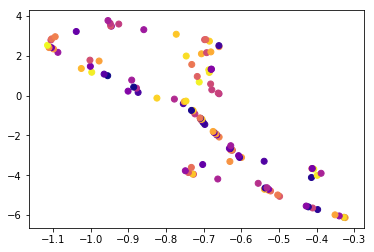

In [263]:
all_authors = writer_feature_subsection['author_list']
unique_authors = list(set(all_authors))
cm = plt.get_cmap('plasma_r',len(unique_authors))
cmap_colors = [cm.colors[unique_authors.index(i)] for i in all_authors]
np.shape(cm.colors)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cmap_colors[:])

In [223]:
# lets do all pairwise correlations
nvals = np.shape(writer_feature_subsection)[0]
matsim = np.ndarray(shape=(nvals,nvals))
for i in range(0,nvals):
    for j in range(0,nvals):
        vec1 = writer_feature_subsection.iloc[i,:-1].values
        vec2 = writer_feature_subsection.iloc[j,:-1].values
        result1 = cos_sim(vec1, vec2)
#         result1 = cosine_similarity(vec1.tolist()[:-1], vec2.tolist()[:-1])
        matsim[i, j] = result1

In [246]:
idx = writer_feature_subsection['author_list'] == 'zachlowe_nba'


In [247]:
np.where(matsim[idx,:] == np.max(matsim[idx,:]))

(array([0]), array([5]))

In [250]:
(matsim[idx,:])

array([[0.99997471, 0.99999712, 0.99999603, 0.99997948, 0.99998168,
        1.        , 0.9999759 , 0.99994412, 0.99994735, 0.99979402,
        0.99990624, 0.99988439, 0.99992839, 0.99997956, 0.99951104,
        0.99984717, 0.99990848, 0.99985454, 0.99991339, 0.99997764,
        0.99979088, 0.99984262, 0.9999573 , 0.99997316, 0.99986631,
        0.99973897, 0.99978749, 0.99995093, 0.99997092, 0.99982864,
        0.99990034, 0.99993435, 0.99997447, 0.99994875, 0.99989654,
        0.99993591, 0.99951427, 0.99990707, 0.99989897, 0.99973007,
        0.99956369, 0.999967  , 0.99955692, 0.99977781, 0.99986229,
        0.99983659, 0.99976508, 0.99972168, 0.99990005, 0.99969558,
        0.99976832, 0.99912909, 0.99965046, 0.99978636, 0.99917296,
        0.99972734, 0.99976332, 0.99959091, 0.99989307, 0.99971395,
        0.99966707, 0.99982486, 0.9998309 , 0.9992932 , 0.9992888 ,
        0.99958293, 0.99972132, 0.99934276, 0.99916115, 0.9996444 ,
        0.99878795, 0.99909121, 0.99948855, 0.99

In [251]:
writer_feature_subsection['author_list'].head()

0        steve-kyler
1      chris-ballard
2        lee-jenkins
3    dennis-chambers
4     jared-zwerling
Name: author_list, dtype: object